In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, datasets, callbacks, losses, optimizers, metrics
import tensorflow.keras.backend as K
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

Downloading the CelebA dataset

In [ ]:
!pip install opendatasets

In [ ]:
import opendatasets as od  # This should work without errors now.
od.download("https://www.kaggle.com/datasets/jessicali9530/celeba-dataset")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username:

Preprocessing the CelebA dataset

In [ ]:
train_data = tf.keras.utils.image_dataset_from_directory(
    "/content/celeba-dataset/img_align_celeba/img_align_celeba",
    labels=None,
    color_mode="rgb",
    image_size=(64, 64),
    batch_size=128,
    shuffle=True,
    seed=42,
    interpolation="bilinear",
)

Found 202599 files.


In [ ]:
def preprocess(img):
 img = tf.cast(img, "float32") / 255.0
 return img
train = train_data.map(lambda x: preprocess(x))

The Sampling layer

In [ ]:
class Sampling(layers.Layer):
  def call(self, inputs):
    z_mean, z_log_var = inputs
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

Encoder & Decoder

In [ ]:
encoder_input = layers.Input(shape=(64, 64, 3), name="encoder_input")
x = layers.Conv2D(32, (3, 3), strides=2, activation="relu", padding="same")(encoder_input)
x = layers.Conv2D(64, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(128, (3, 3), strides=2, activation="relu", padding="same")(x)
shape_before_flattening = K.int_shape(x)[1:]
x = layers.Flatten()(x)
z_mean = layers.Dense(200, name="z_mean")(x)  # Change the output dimension to 200
z_log_var = layers.Dense(200, name="z_log_var")(x) # Change the output dimension to 200
z = Sampling()([z_mean, z_log_var])
encoder = models.Model(encoder_input, [z_mean, z_log_var, z], name="encoder")

In [ ]:
decoder_input = layers.Input(shape=(200,), name="decoder_input")
x = layers.Dense(np.prod(shape_before_flattening))(decoder_input)
x = layers.Reshape(shape_before_flattening)(x)
x = layers.Conv2DTranspose(128, (3, 3), strides=2, activation = 'relu', padding="same")(x)
x = layers.Conv2DTranspose(64, (3, 3), strides=2, activation = 'relu', padding="same")(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation = 'relu', padding="same")(x)
decoder_output = layers.Conv2D(3,(3, 3), # Change the number of filters to 3 to match the input image channels
 strides = 1,
 activation="sigmoid",
 padding="same",
 name="decoder_output"
 )(x)
decoder = models.Model(decoder_input, decoder_output)

In [ ]:
class VAE(models.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstruction = self.decoder(z)
        return z_mean, z_log_var, reconstruction

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, reconstruction = self(data)
            reconstruction_loss = tf.reduce_mean(
                500
                * losses.binary_crossentropy(data, reconstruction, axis=(1, 2, 3))
            )
            kl_loss = tf.reduce_mean(
                tf.reduce_sum(
                    -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                    axis=1,
                )
            )
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {m.name: m.result() for m in self.metrics}
vae = VAE(encoder, decoder)
vae.compile(optimizer="adam")
vae.fit(
    train,
    epochs=5,
    batch_size=100
    )

Epoch 1/5
1583/1583 ━━━━━━━━━━━━━━━━━━━━ 95s 55ms/step - kl_loss: 9.0202 - reconstruction_loss: 292.0804 - total_loss: 301.1006
Epoch 2/5
1583/1583 ━━━━━━━━━━━━━━━━━━━━ 82s 52ms/step - kl_loss: 12.0847 - reconstruction_loss: 272.5012 - total_loss: 284.5858
Epoch 3/5
1583/1583 ━━━━━━━━━━━━━━━━━━━━ 82s 51ms/step - kl_loss: 12.5311 - reconstruction_loss: 271.2016 - total_loss: 283.7326
Epoch 4/5
1583/1583 ━━━━━━━━━━━━━━━━━━━━ 79s 49ms/step - kl_loss: 12.7642 - reconstruction_loss: 270.4799 - total_loss: 283.2441
Epoch 5/5
1583/1583 ━━━━━━━━━━━━━━━━━━━━ 83s 50ms/step - kl_loss: 12.8880 - reconstruction_loss: 270.0966 - total_loss: 282.9846


 Generating new faces from the latent space

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 833ms/step


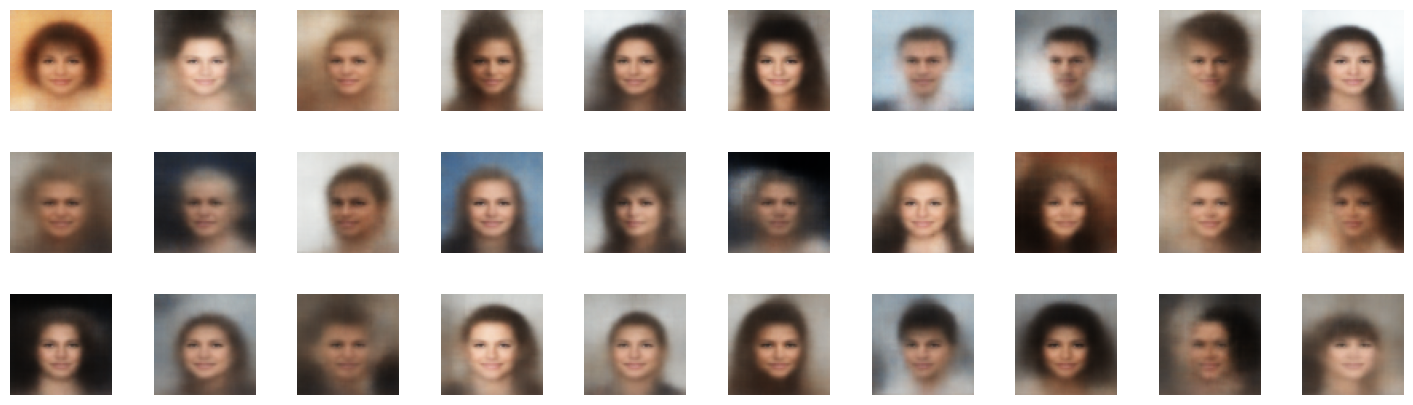

In [ ]:
grid_width, grid_height = (10,3)
z_sample = np.random.normal(size=(grid_width * grid_height, 200))
reconstructions = decoder.predict(z_sample)
fig = plt.figure(figsize=(18, 5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(grid_width * grid_height):
  ax = fig.add_subplot(grid_height, grid_width, i + 1)
  ax.axis("off")
  ax.imshow(reconstructions[i, :, :])

Boom!!!!! these are a entirely a new images od people that never existed in the world Isn't that amazing I will soon upload a scratch code for GANs & Diffusion models as well